# Neural Networks on MNIST

This Jupyter notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Source: https://colab.research.google.com/github/chokkan/deeplearningclass/blob/master/mnist.ipynb

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The cell below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [ ]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [ ]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


## Visualize the dataset

9


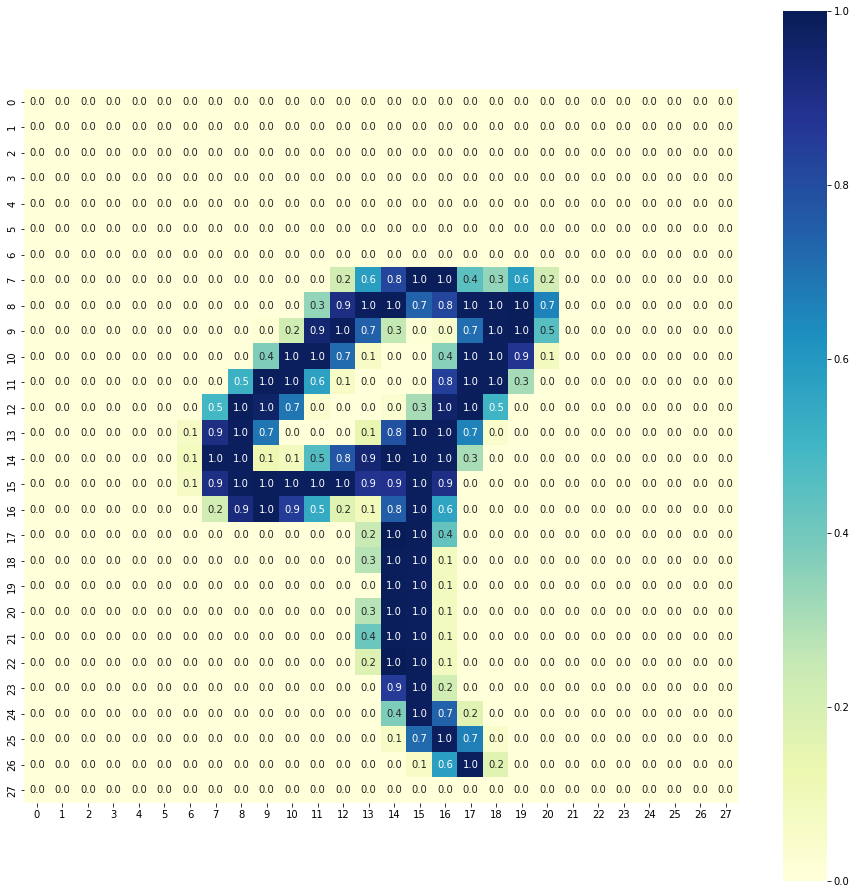

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 4

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## Install a library for plotting loss and accuracy values

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 11.7 MB/s 


## Perceptron algorithm for single-layer neural network

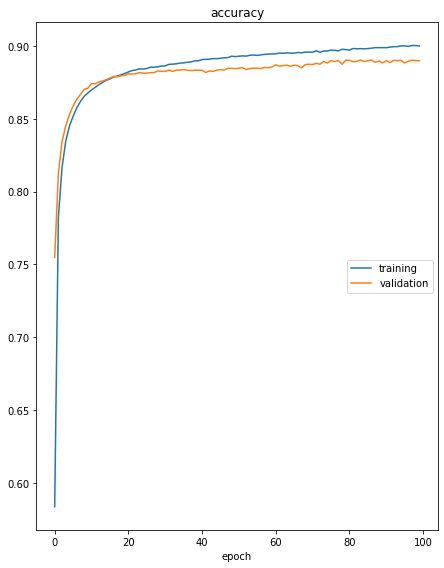

accuracy
	training         	 (min:    0.584, max:    0.900, cur:    0.900)
	validation       	 (min:    0.755, max:    0.890, cur:    0.890)
Accuracy: 0.8899 (test), 0.9001 (train)


In [ ]:
import numpy as np
from livelossplot import PlotLosses

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = data['train_y']
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred != y:
            W[y] += x * eta
            W[y_pred] -= x * eta
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
    
    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest), 
    float(num_correct_train) / len(Ytrain)
    ))

## Stochastic gradient descent for single-layer neural network

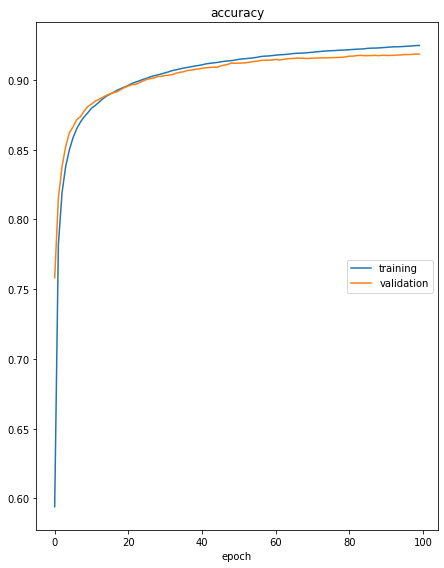

accuracy
	training         	 (min:    0.594, max:    0.925, cur:    0.925)
	validation       	 (min:    0.758, max:    0.919, cur:    0.919)
Accuracy: 0.9186 (test), 0.9248 (train)


In [ ]:
import numpy as np
from livelossplot import PlotLosses

def softmax(x):
    # Result of softmax are invariant even if we add/subtract a constant.
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
    
data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = label_to_onehot(data['train_y'], 10)
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    num_correct_train = 0
    
    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        W += np.outer(eta * (y - y_pred), x)
        if  np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1
    
    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
            
    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest), 
    float(num_correct_train) / len(Ytrain)
    ))